In [29]:
import numpy as np
import pandas as pd
import loadData
import monteCarloClass
import time

In [ ]:
import os
import json
import glob
import pandas as pd
from pathlib import Path

def load_all_model_results():
    """Load all model fit results from the model_fits directory"""
    results = []
    
    # Find all JSON files in model_fits directory
    json_files = glob.glob("model_fits/**/*.json", recursive=True)

    
    
    for file_path in json_files:
        
        if "ln1" in os.path.basename(file_path): # ln1 should be ignored as its the first participant and only half of the data is not corrupt
            continue
        
        # if in filename "all_all", skip
        if "all" in os.path.basename(file_path):
            continue

        if "loglinear" in os.path.basename(file_path).lower():
            continue
        try:
            with open(file_path, 'r') as f:
                result = json.load(f)
            
            # Extract participant ID and model type from filename if not in data
            filename = os.path.basename(file_path)
            parts = filename.replace('.json', '').split('_')
            #print(parts)
            if 'participantID' not in result:
                result['participantID'] = parts[0]

            
            result['modelType'] = parts[1]+"_"+parts[3]
            # if result['modelType'] in "logLinearMismatch_sharedPrior":
            #     continue
            
            if parts[2]!="LapseFree":
                #print("Lapse fixed model, skipping")
                continue
            

            results.append(result)
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    return results

# Load all results
all_results = load_all_model_results()
print(f"Loaded {len(all_results)} model fit results")

# Convert to DataFrame for easier analysis
df_results = pd.DataFrame(all_results)
print(f"Participants: {sorted(df_results['participantID'].unique())}")
print(f"Models: {sorted(df_results['modelType'].unique())}")



Loaded 55 model fit results
Participants: ['as', 'dt', 'hh', 'ip', 'ln2', 'mh', 'ml', 'mt', 'oy', 'qs', 'sx']
Models: ['fusionOnlyLogNorm_sharedPrior', 'lognorm_sharedPrior', 'probabilityMatchingLogNorm_sharedPrior', 'selection_sharedPrior', 'switchingFree_sharedPrior']


In [31]:
def rename_model(best_models_df, old_name, new_name):
    """Rename a model name across all relevant DataFrames and variables."""
    # Rename in df_results
    best_models_df['modelType'] = best_models_df['modelType'].replace(old_name, new_name)
    
    # Rename in best_models_df
    best_models_df['best_model'] = best_models_df['best_model'].replace(old_name, new_name)
    
    # Rename in comparison_table_df
    comparison_table_df.columns = comparison_table_df.columns.map(
        lambda col: col if col[1] != old_name else (col[0], new_name)
    )
    
    # Rename in delta_aic_table
    delta_aic_table.columns = delta_aic_table.columns.str.replace(old_name, new_name)
    
    # Rename in ll_table
    ll_table.columns = ll_table.columns.str.replace(old_name, new_name)
    
    # Rename in simple_table
    simple_table.columns = simple_table.columns.str.replace(old_name, new_name)
    
    # Update participant_best_models
    global participant_best_models
    participant_best_models = [
        new_name if model == old_name else model for model in participant_best_models
    ]
    
    # Update ll_best_models
    global ll_best_models
    ll_best_models = [
        new_name if model == old_name else model for model in ll_best_models
    ]
    
    # Print confirmation
    print(f"Model name '{old_name}' has been renamed to '{new_name}'")


In [32]:
# Find best model for each participant (lowest AIC)
def find_best_models(df_results):
    """Find the best fitting model for each participant based on AIC"""
    best_models = []
    
    for participant in df_results['participantID'].unique():
        participant_data = df_results[df_results['participantID'] == participant]
        
        if len(participant_data) > 0:
            # Find model with lowest AIC
            best_idx = participant_data['AIC'].idxmin()
            best_model = participant_data.loc[best_idx]

            # delta AIC and BIC compared to the best model
            for _, row in participant_data.iterrows():
                if row['modelType'] != best_model['modelType']:
                    delta_AIC = row['AIC'] - best_model['AIC']
                    delta_BIC = row['BIC'] - best_model['BIC']
                    print(f"Participant {participant}, Model {row['modelType']} vs Best Model {best_model['modelType']}: ΔAIC={delta_AIC:.2f}, ΔBIC={delta_BIC:.2f}")
            
            best_models.append({
                'participantID': participant,
                'best_model': best_model['modelType'],
                'AIC': best_model['AIC'],
                'BIC': best_model['BIC'],
                'logLikelihood': best_model['logLikelihood'],
                'delta_AIC': delta_AIC,
                'delta_BIC': delta_BIC
            })
    
    return pd.DataFrame(best_models)

# Find best models
best_models_df = find_best_models(df_results)
print("\nBest Model for Each Participant (based on AIC):")
print("=" * 60)
print(best_models_df.round(3))

# Model performance summary
print(f"\nModel Performance Summary:")
print("=" * 40)
model_counts = best_models_df['best_model'].value_counts()
for model, count in model_counts.items():
    percentage = (count / len(best_models_df)) * 100
    print(f"{model}: {count} participants ({percentage:.1f}%)")

Participant sx, Model lognorm_sharedPrior vs Best Model switchingFree_sharedPrior: ΔAIC=6.57, ΔBIC=2.27
Participant sx, Model fusionOnlyLogNorm_sharedPrior vs Best Model switchingFree_sharedPrior: ΔAIC=8.51, ΔBIC=-0.11
Participant sx, Model selection_sharedPrior vs Best Model switchingFree_sharedPrior: ΔAIC=6.71, ΔBIC=2.41
Participant sx, Model probabilityMatchingLogNorm_sharedPrior vs Best Model switchingFree_sharedPrior: ΔAIC=3.42, ΔBIC=-0.89
Participant mt, Model lognorm_sharedPrior vs Best Model fusionOnlyLogNorm_sharedPrior: ΔAIC=10.10, ΔBIC=13.98
Participant mt, Model probabilityMatchingLogNorm_sharedPrior vs Best Model fusionOnlyLogNorm_sharedPrior: ΔAIC=4.94, ΔBIC=8.82
Participant mt, Model selection_sharedPrior vs Best Model fusionOnlyLogNorm_sharedPrior: ΔAIC=9.58, ΔBIC=13.46
Participant mt, Model switchingFree_sharedPrior vs Best Model fusionOnlyLogNorm_sharedPrior: ΔAIC=0.83, ΔBIC=8.59
Participant mh, Model probabilityMatchingLogNorm_sharedPrior vs Best Model fusionOnlyLogN

In [33]:
# Rename models in df_results BEFORE creating any tables
df_results['modelType'] = df_results['modelType'].replace({
    'probabilityMatchingLogNorm_sharedPrior': 'Probbility-Matching CI',
    'probabilityMatchingLogNorm': 'Prob-Matching CI',
    'probabilityMatching_sharedPrior': 'prob-Matching-Gauss',
    'switchingFree_sharedPrior': 'Free Switching',
    'switching_sharedPrior': 'Noise Dep. Switching',
    'switchingWithConflict_sharedPrior': 'Noise Dep. Switching + Conflict',
    'fusionOnly_sharedPrior': 'Fusion Only',
    'fusionOnlyLogNorm_sharedPrior': 'Forced Fusion',
    'lognorm_sharedPrior': 'Averaging CI',
    'gaussian_sharedPrior': 'Gaussian-Space CI',
    'lognorm_contextualPrior': 'Log-Space CI + Context',
    'logLinearMismatch_sharedPrior': 'Log-Linear Mismatch Avg CI',
    'selection_sharedPrior': 'Selection CI',
})

df_results["nParameters"] = [len(params) for params in df_results["fittedParams"]]
df_results["AIC_recalculated"] = 2 * df_results["nParameters"] - 2 * df_results["logLikelihood"]

print("Model names updated successfully!")
print(f"Current model types: {sorted(df_results['modelType'].unique())}")

Model names updated successfully!
Current model types: ['Averaging CI', 'Forced Fusion', 'Free Switching', 'Probbility-Matching CI', 'Selection CI']


In [34]:
df_results

,participantID,modelType,fittedParams,AIC,BIC,logLikelihood,n_conditions,nParameters,AIC_recalculated
0,sx,Free Switching,"[0.00100676619969306, 0.05494942788865409, 0.3...",2145.147761,2179.597963,-1064.573881,548,8,2145.147761
1,sx,Averaging CI,"[0.0010001342422045756, 0.33921005301171236, 0...",2151.719866,2181.863793,-1068.859933,548,7,2151.719866
2,sx,Forced Fusion,"[0.0010010687986155842, 0.33265441676415497, 0...",2153.654938,2179.492590,-1070.827469,548,6,2153.654938
3,sx,Selection CI,"[0.023234512085853337, 0.17895699405860788, 0....",2151.861971,2182.005898,-1068.930985,548,7,2151.861971
4,sx,Probbility-Matching CI,"[0.013386030469147936, 0.24978987224322502, 0....",2148.562957,2178.706884,-1067.281479,548,7,2148.562957
5,mt,Averaging CI,"[0.060016318320364956, 0.14157681437677516, 0....",2207.909712,2235.073443,-1096.954856,358,7,2207.909712
6,mt,Forced Fusion,"[0.03511450789570808, 0.15256166017055506, 0.4...",2197.809930,2221.093127,-1092.904965,358,6,2197.809930
7,mt,Probbility-Matching CI,"[0.035726815013191665, 0.15696676968664147, 0....",2202.745654,2229.909385,-1094.372827,358,7,2202.745654
8,mt,Selection CI,"[0.05397702112051753, 0.07375835781862317, 0.1...",2207.386095,2234.549826,-1096.693047,358,7,2207.386095
9,mt,Free Switching,"[0.037807366781214546, 0.14188179661953804, 0....",2198.640728,2229.684992,-1091.320364,358,8,2198.640728


In [35]:
# #df_results["delta_AIC"]

# for i, row in df_results.iterrows():
#     participant = row["participantID"]
#     model = row["modelType"]
#     participant_data = df_results[df_results["participantID"] == participant]
#     base_aic_participant = participant_data[participant_data["modelType"] == "Log-Space Causal"]["AIC"].values[0]
#     best_ll_participant = participant_data["logLikelihood"].max()
#     df_results.at[i, "delta_AIC"] = row["AIC"] - base_aic_participant
#     df_results.at[i, "delta_LL"] = best_ll_participant - row["logLikelihood"]
    

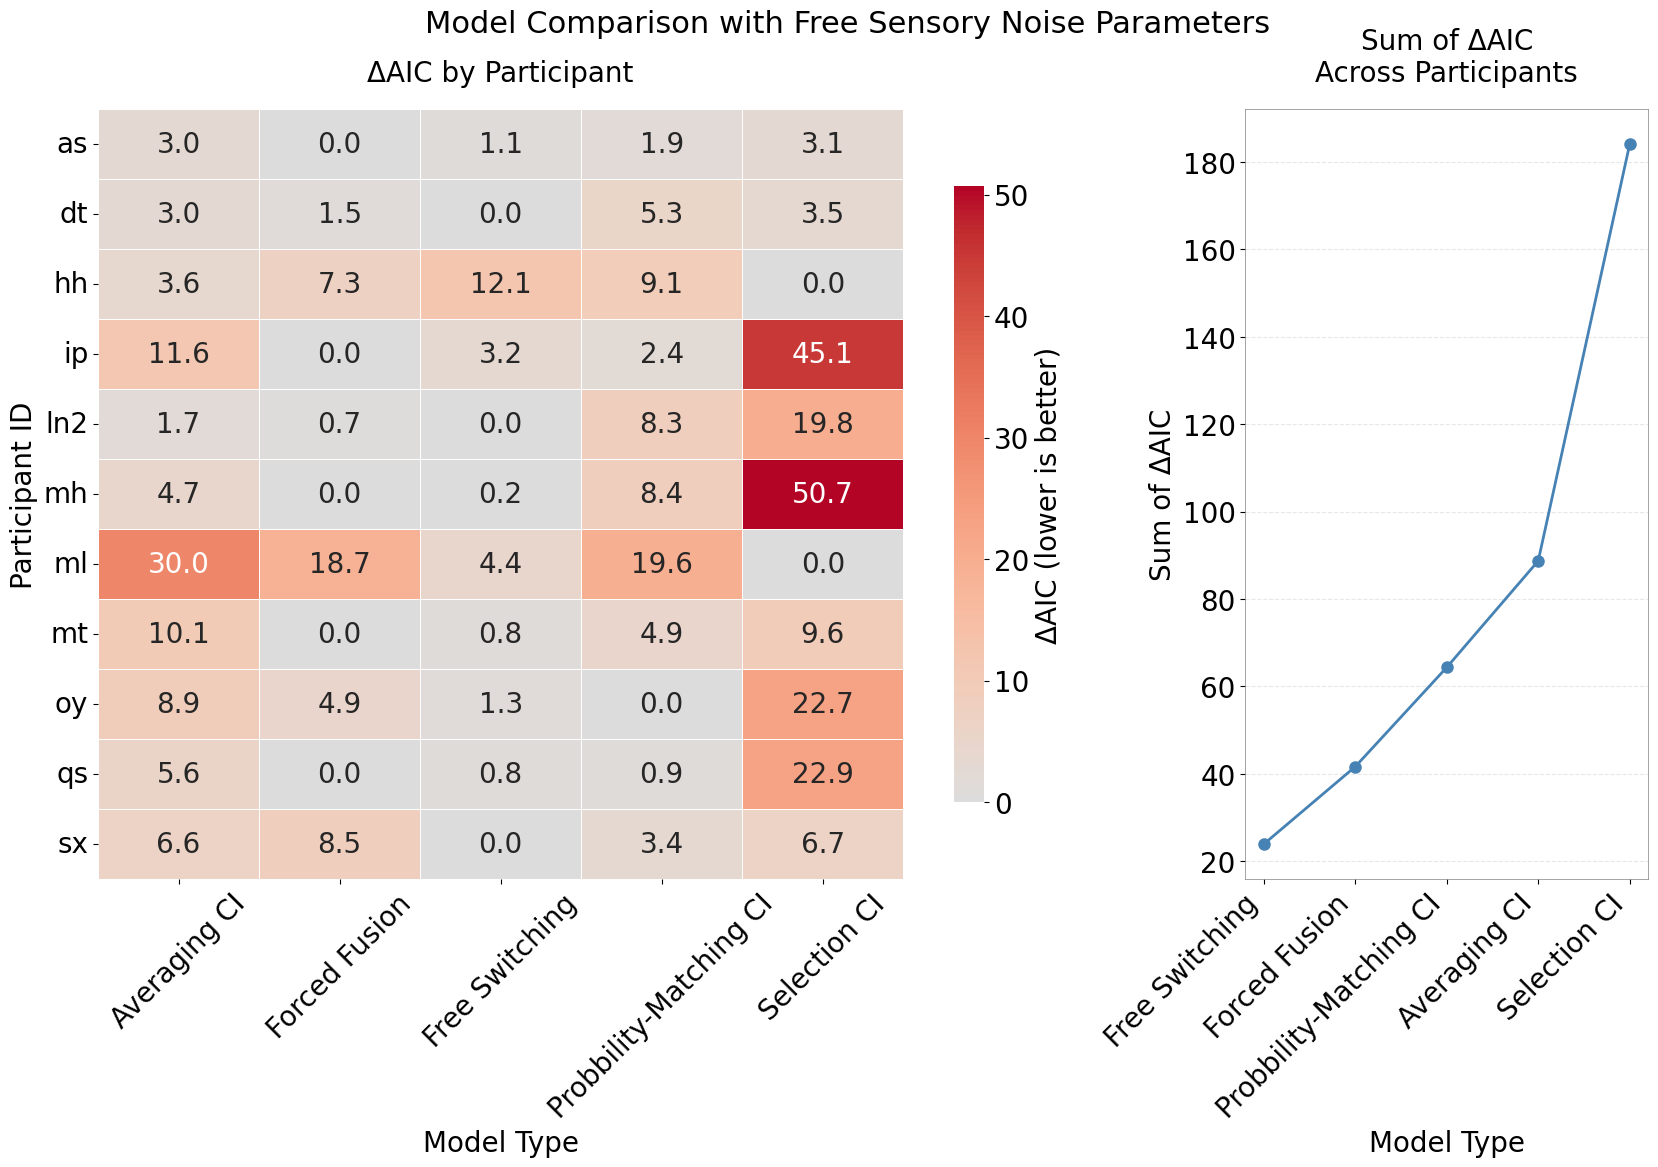


Best Model Counts (excluding benchmark models):
best_model
fusionOnlyLogNorm_sharedPrior             5
switchingFree_sharedPrior                 3
selection_sharedPrior                     2
probabilityMatchingLogNorm_sharedPrior    1
Name: count, dtype: int64

Best Model Counts (excluding benchmark models):
best_model
fusionOnlyLogNorm_sharedPrior             5
switchingFree_sharedPrior                 3
selection_sharedPrior                     2
probabilityMatchingLogNorm_sharedPrior    1
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

In [44]:
compTableTitle="Model Comparison with Free Sensory Noise Parameters"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sorted_model_comparison_table(
    df_results,
    compBase="AIC",
    exclude_from_counts=("Forced Fusion", "Fusion Only", "Fusion Only-Log", "fusionOnly", "fusionOnlyLogNorm"),
    include_in_heatmap=True,   # keep forced fusion visible in heatmap
    sort_by="sum_delta",       # "sum_delta" or "sum_compBase"
):
    """
    - Computes Δ(compBase) within participant (relative to best model for that participant).
    - Sorts participants by sum of Δ(compBase) (default).
    - Heatmap shows Δ(compBase) for all models (by default).
    - Best-model distribution EXCLUDES models in exclude_from_counts (benchmark models).
    """

    df = df_results.copy()

    # Ensure numeric
    df[compBase] = pd.to_numeric(df[compBase], errors="coerce")

    # Δ(compBase) per participant
    df["delta"] = df.groupby("participantID")[compBase].transform(lambda x: x - x.min())

    # Sorting participants
    if sort_by == "sum_delta":
        participant_sort = df.groupby("participantID")["delta"].sum().sort_values()
    elif sort_by == "sum_compBase":
        participant_sort = df.groupby("participantID")[compBase].sum().sort_values()
    else:
        raise ValueError("sort_by must be 'sum_delta' or 'sum_compBase'")
    #sorted_participants = participant_sort.index.tolist()
    # not sort by sum_delta, just sort by participantID
    sorted_participants = df["participantID"].unique().tolist()
    sorted_participants = sorted(df["participantID"].unique())

    # Heatmap dataframe
    if include_in_heatmap:
        df_heat = df
    else:
        df_heat = df[~df["modelType"].isin(exclude_from_counts)].copy()

    heat = df_heat.pivot(index="participantID", columns="modelType", values="delta").reindex(sorted_participants)

    # Best-model per participant (for counts), excluding benchmark models
    df_counts = df[~df["modelType"].isin(exclude_from_counts)].copy()

    best_models = []
    for pid in sorted_participants:
        d = df_counts[df_counts["participantID"] == pid]
        if len(d) == 0:
            best_models.append(None)  # edge case if everything excluded
            continue
        best_models.append(d.loc[d[compBase].idxmin(), "modelType"])

    best_models_clean = [m for m in best_models if m is not None]
    best_model_counts = pd.Series(best_models_clean).value_counts()

    # Calculate model sums for third panel
    model_sums = df.groupby("modelType")["delta"].sum().sort_values()

    # Plot with two panels

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={"width_ratios": [2.5, 1]})

    fig.suptitle(compTableTitle, fontsize=22)


    heatmap = sns.heatmap(
        heat,
        annot=True,
        fmt=".1f",
        cmap="coolwarm",  # Use a perceptually uniform colormap
        center=0,         # Center the colormap at 0
        vmin=0,           # Set the minimum value for the color range
        vmax=heat.values.max(),  # Set the maximum value for the color range
        ax=ax1,
        cbar_kws={"label": f"Δ{compBase} (lower is better)", "shrink": 0.8},
        linewidths=0.5,
        linecolor="white",
        annot_kws={"fontsize": 20}
    )
    
    # Increase colorbar label font size
    cbar = heatmap.collections[0].colorbar
    cbar.set_label(f"Δ{compBase} (lower is better)", fontsize=20)
    cbar.ax.tick_params(labelsize=20)
    
    ax1.set_title(f"Δ{compBase} by Participant", fontsize=20, pad=20)
    ax1.set_ylabel("Participant ID", fontsize=20)
    ax1.set_xlabel("Model Type", fontsize=20)
    ax1.tick_params(axis="x", rotation=45, labelsize=20)
    ax1.tick_params(axis="y", rotation=0, labelsize=20)
    ax1.set_facecolor('white')  # Set axes background to white
    fig.patch.set_facecolor('white')  # Set figure background to white

    # Remove gridlines from heatmap
    for _, spine in ax1.spines.items():
        spine.set_visible(False)

    # Sum of ΔAIC by model panel
    ax2.plot(range(len(model_sums)), model_sums.values, marker="o", linestyle="-", linewidth=2, markersize=8, color='steelblue')
    ax2.set_xticks(range(len(model_sums)))
    ax2.set_xticklabels(model_sums.index, rotation=45, ha='right', fontsize=20)
    ax2.set_ylabel(f"Sum of Δ{compBase}", fontsize=20)
    ax2.set_xlabel("Model Type", fontsize=20)
    ax2.set_title(f"Sum of Δ{compBase}\nAcross Participants", fontsize=20, pad=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    ax2.set_facecolor('white')
    for _, spine in ax2.spines.items():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)


    plt.savefig('model comp w free sensory noise.png', dpi=600)
    #plt.tight_layout()
    plt.show()
    return heat, best_models, participant_sort

heat, best_models, participant_sort = plot_sorted_model_comparison_table(
    df_results,
    compBase="AIC",
    exclude_from_counts=(),   # Include all models in counts
    include_in_heatmap=True,
    sort_by="sum_delta"
)



print("\nBest Model Counts (excluding benchmark models):")
print(model_counts)
#save as png
plt.savefig("model comp w fixed sensory noise.png", dpi=300, bbox_inches='tight')
print("\nBest Model Counts (excluding benchmark models):")
print(model_counts)

Participants sorted by sum of delta_AIC across all models (lowest to highest):
Delta_AIC sums: {'as': 9.028609051695184, 'dt': 13.327856846672603, 'sx': 25.20868751443777, 'mt': 25.442471704134732, 'qs': 30.19292403076679, 'ln2': 30.519320971913203, 'hh': 32.123437396135614, 'oy': 37.776155302712596, 'ip': 62.31484844013221, 'mh': 63.99466718649546, 'ml': 72.68180951755949}


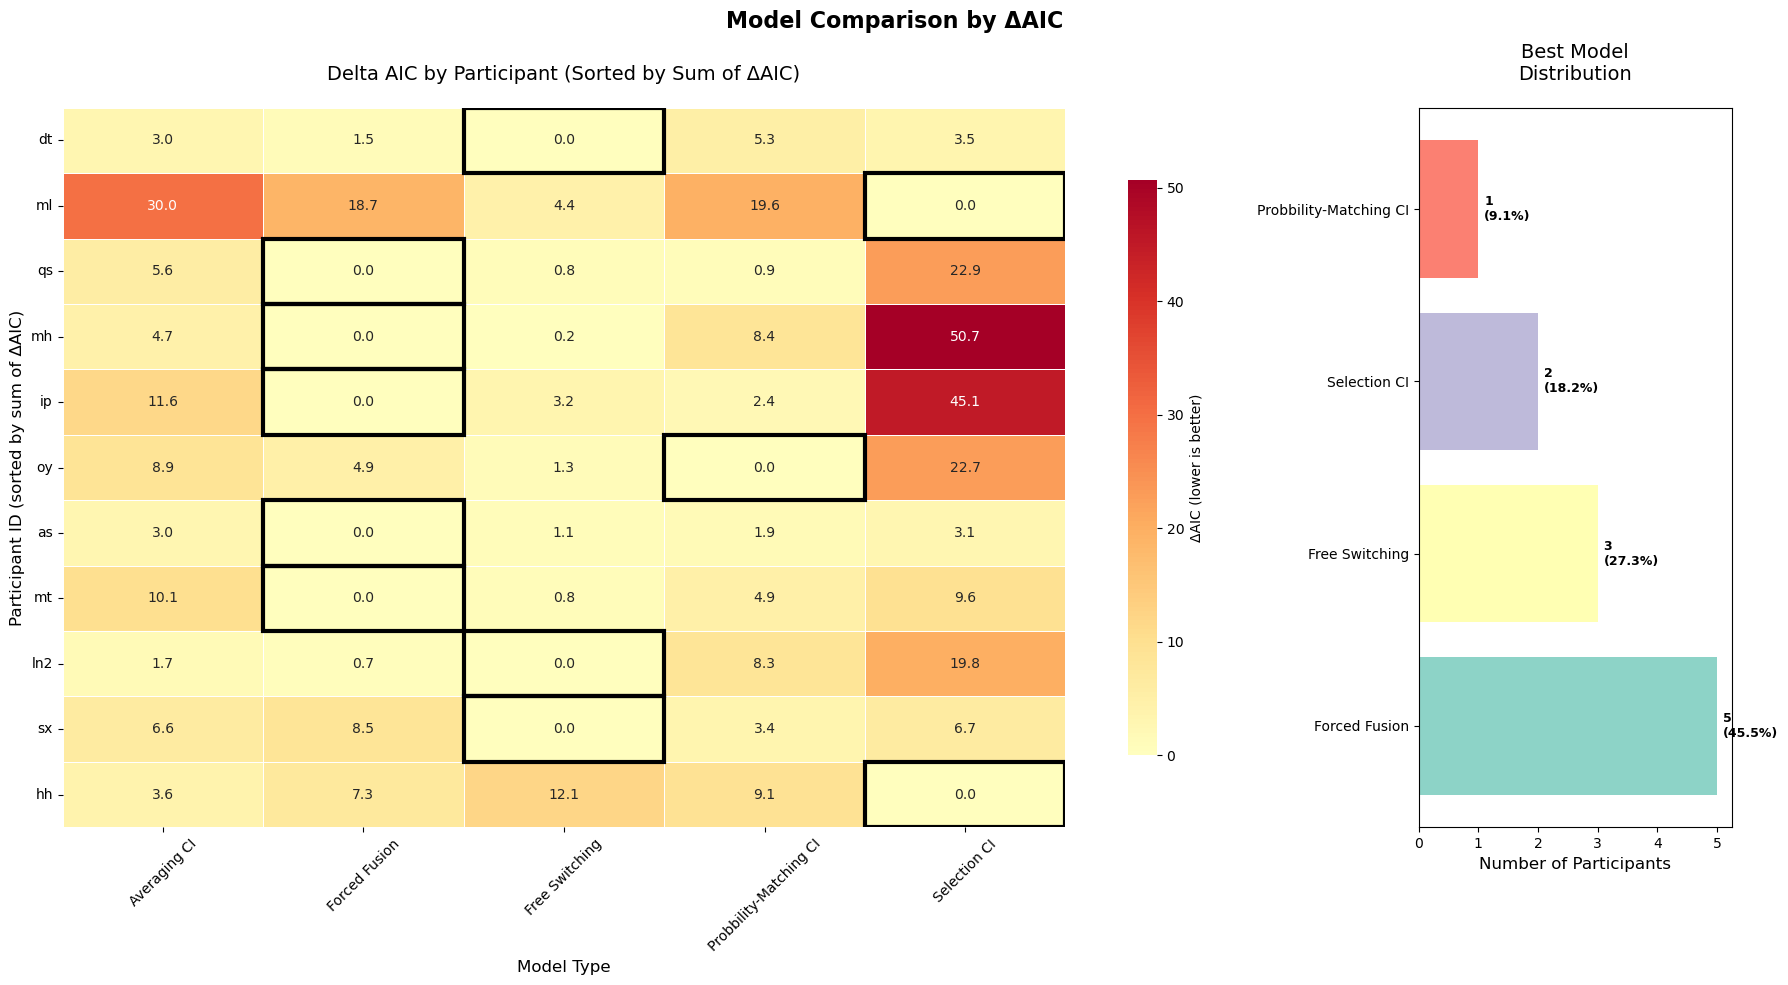

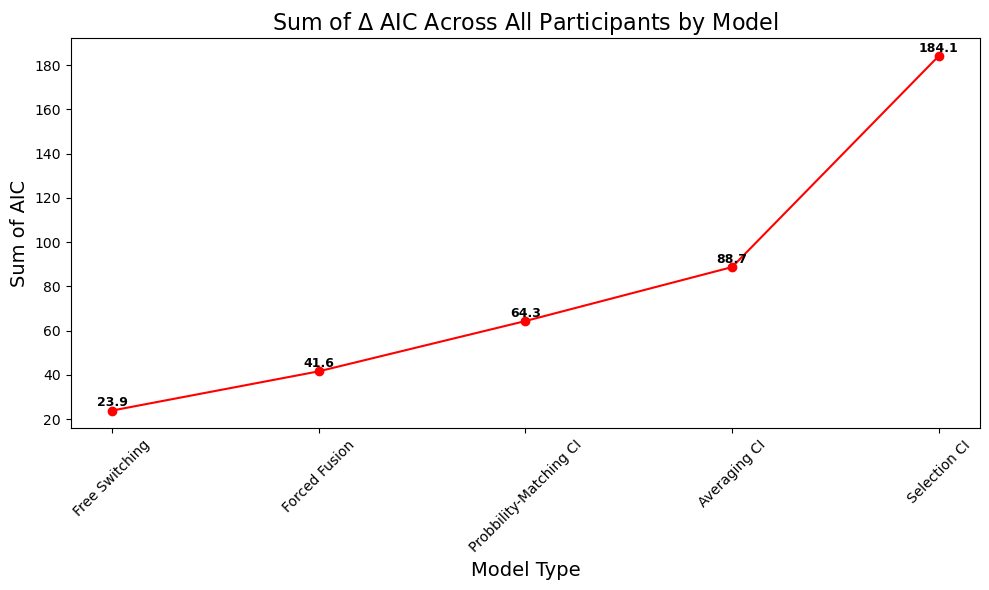

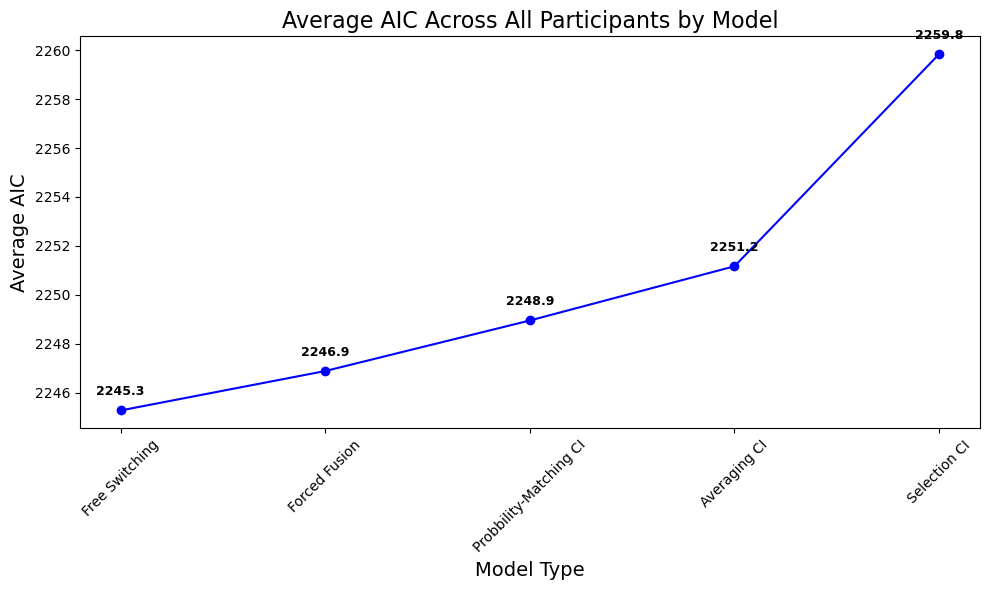

1    dt           12765.1    Free Switching     2550.4     Poor fit       
2    ml           12552.2    Selection CI       2495.9     Poor fit       
3    qs           12536.0    Forced Fusion      2501.2     Poor fit       
4    mh           12219.8    Forced Fusion      2431.2     Poor fit       
5    ip           12077.9    Forced Fusion      2403.1     Poor fit       
6    oy           11663.6    Probbility-Matching CI 2325.2     Poor fit       
7    as           11286.7    Forced Fusion      2255.5     Poor fit       
8    mt           11014.5    Forced Fusion      2197.8     Poor fit       
9    ln2          10910.1    Free Switching     2175.9     Poor fit       
10   sx           10750.9    Free Switching     2145.1     Poor fit       
11   hh           5996.3     Selection CI       1192.8     Poor fit       


In [37]:
# Calculate delta_AIC for each model relative to the best model per participant
df_results['delta_AIC'] = df_results.groupby('participantID')['AIC'].transform(lambda x: x - x.min())

# Sort participants by sum of delta_AIC across all models (lower sum = better overall performance)
participant_delta_sums = df_results.groupby('participantID')['delta_AIC'].sum().sort_values()
sorted_participants = participant_delta_sums.index.tolist()
print("Participants sorted by sum of delta_AIC across all models (lowest to highest):")
print(f"Delta_AIC sums: {participant_delta_sums.to_dict()}")

import matplotlib.pyplot as plt
import seaborn as sns

# Create enhanced table-style visualization
def plot_sorted_model_comparison_table(df_results,compBase='AIC', notFusion=1, sumCompBase=0):
    
    if notFusion:
        removeModels= ["Fusion Only", "Fusion Only-Log"]
        df_results = df_results[~df_results['modelType'].isin(removeModels)]
    """Create a comprehensive table plot with participants sorted by sum of delta_AIC"""
    
    # Calculate delta_AIC for each model relative to the best model
    df_results['delta_AIC'] = df_results.groupby('participantID')[compBase].transform(lambda x: x - x.min())
    
    # Sort participants by sum of delta_AIC across all models
    participant_delta_sums = df_results.groupby('participantID')['logLikelihood'].sum().sort_values()
    sorted_participants = participant_delta_sums.index.tolist()
    
    # Create the pivot table with sorted participants
    df_delta_aic = df_results.pivot(index='participantID', columns='modelType', values='delta_AIC')
    df_delta_aic = df_delta_aic.reindex(sorted_participants)
    
    # Find best model for each participant
    best_models = []
    for participant in sorted_participants:
        participant_data = df_results[df_results['participantID'] == participant]
        best_model = participant_data.loc[participant_data[compBase].idxmin(), 'modelType']
        best_models.append(best_model)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [4, 1]})
    fig.suptitle(f'Model Comparison by Δ{compBase}', fontsize=16, fontweight='bold')
    
    # Main heatmap with delta_AIC values
    sns.heatmap(df_delta_aic, 
                annot=True, 
                fmt='.1f', 
                cmap='RdYlBu_r', 
                center=0,
                ax=ax1,
                cbar_kws={'label': f'Δ{compBase} (lower is better)', 'shrink': 0.8},
                linewidths=0.5,
                linecolor='white')
    
    ax1.set_title(f'Delta {compBase} by Participant (Sorted by Sum of Δ{compBase})', fontsize=14, pad=20)
    ax1.set_ylabel(f'Participant ID (sorted by sum of Δ{compBase})', fontsize=12)
    ax1.set_xlabel('Model Type', fontsize=12)
    
    # Rotate x-axis labels for better readability
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', rotation=0, labelsize=10)
    
    # Add best model indicators
    for i, (participant, best_model) in enumerate(zip(sorted_participants, best_models)):
        # Find column index of best model
        model_cols = df_delta_aic.columns.tolist()
        if best_model in model_cols:
            col_idx = model_cols.index(best_model)
            # Add a star or border to highlight best model
            rect = plt.Rectangle((col_idx, i), 1, 1, fill=False, edgecolor='black', lw=3)
            ax1.add_patch(rect)
    
    # Side panel: Best model summary
    best_model_counts = pd.Series(best_models).value_counts()
    colors = plt.cm.Set3(range(len(best_model_counts)))
    
    bars = ax2.barh(range(len(best_model_counts)), best_model_counts.values, color=colors)
    ax2.set_yticks(range(len(best_model_counts)))
    ax2.set_yticklabels(best_model_counts.index, fontsize=10)
    ax2.set_xlabel('Number of Participants', fontsize=12)
    ax2.set_title('Best Model\nDistribution', fontsize=14, pad=20)
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, best_model_counts.values)):
        percentage = (count / len(sorted_participants)) * 100
        ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{count}\n({percentage:.1f}%)', 
                ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    # we want to plot a line chart of sum of AIC per model
    model_sums = df_results.groupby('modelType')["delta_AIC"].sum().sort_values()
    plt.figure(figsize=(10, 6))
    plt.plot(model_sums.index, model_sums.values, marker='o', linestyle='-', color='r')
    plt.title(f'Sum of $\Delta$ AIC Across All Participants by Model', fontsize=16)
    plt.xlabel('Model Type', fontsize=14)
    plt.ylabel(f'Sum of {compBase}', fontsize=14)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    # Add value labels on points
    for i, value in enumerate(model_sums.values):
        plt.text(i, value + 0.5, f'{value:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Another plot to show average AIC per model as a line plot
    model_means = df_results.groupby('modelType')[compBase].mean().sort_values()
    plt.figure(figsize=(10, 6))
    plt.plot(model_means.index, model_means.values, marker='o', linestyle='-', color='b')
    # Add value labels on points
    for i, value in enumerate(model_means.values):
        plt.text(i, value + 0.5, f'{value:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    plt.title(f'Average {compBase} Across All Participants by Model', fontsize=16)
    plt.xlabel('Model Type', fontsize=14)
    plt.ylabel(f'Average {compBase}', fontsize=14)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()


    
    for rank, participant in enumerate(sorted_participants, 1):
        participant_data = df_results[df_results['participantID'] == participant]
        sum_delta_aic = participant_data[compBase].sum()
        min_delta_aic = participant_data[compBase].min()
        best_model = participant_data.loc[participant_data[compBase].idxmin(), 'modelType']
        
        if sum_delta_aic <= 5:
            performance = "Excellent fit"
        elif sum_delta_aic <= 15:
            performance = "Good fit"
        elif sum_delta_aic <= 30:
            performance = "Moderate fit"
        else:
            performance = "Poor fit"
            
        print(f"{rank:<4} {participant:<12} {sum_delta_aic:<10.1f} {best_model:<18} {min_delta_aic:<10.1f} {performance:<15}")
    
    return df_delta_aic, best_models, participant_delta_sums

# Create the enhanced visualization
delta_aic_table, participant_best_models, delta_sums = plot_sorted_model_comparison_table(df_results,compBase='AIC', notFusion=0,sumCompBase=1)

In [38]:
# Simple Model Comparison Table with Log Likelihoods
def create_simple_comparison_table(df_results):
    """Create a simple comparison table focused on log likelihoods"""
    
    # Pivot to show log likelihoods for each participant-model combination
    log_likelihood_table = df_results.pivot(
        index='participantID', 
        columns='modelType', 
        values='logLikelihood'
    )
    
    # Sort participants by ID for consistent ordering
    log_likelihood_table = log_likelihood_table.sort_index()
    
    return log_likelihood_table

# Create the simple comparison table
simple_table = create_simple_comparison_table(df_results)

print("Model Comparison Table - Log Likelihoods")
print("=" * 80)
print("Higher values indicate better fit")
print("=" * 80)
print()

# Display with better formatting
pd.set_option('display.float_format', '{:.2f}'.format)
display(simple_table)

# Reset display options
pd.reset_option('display.float_format')

Model Comparison Table - Log Likelihoods
Higher values indicate better fit



modelType,Averaging CI,Forced Fusion,Free Switching,Probbility-Matching CI,Selection CI
participantID,,,,,
as,-1122.25,-1121.77,-1120.30,-1121.74,-1122.31
dt,-1269.67,-1269.95,-1267.18,-1270.81,-1269.95
hh,-591.22,-594.05,-594.49,-593.99,-589.42
ip,-1200.37,-1195.56,-1195.15,-1195.74,-1217.13
ln2,-1081.79,-1082.30,-1079.95,-1085.13,-1090.86
mh,-1210.93,-1209.58,-1207.67,-1212.80,-1233.93
ml,-1255.95,-1251.29,-1242.14,-1250.77,-1240.95
mt,-1096.95,-1092.90,-1091.32,-1094.37,-1096.69
oy,-1160.03,-1159.04,-1155.22,-1155.58,-1166.94


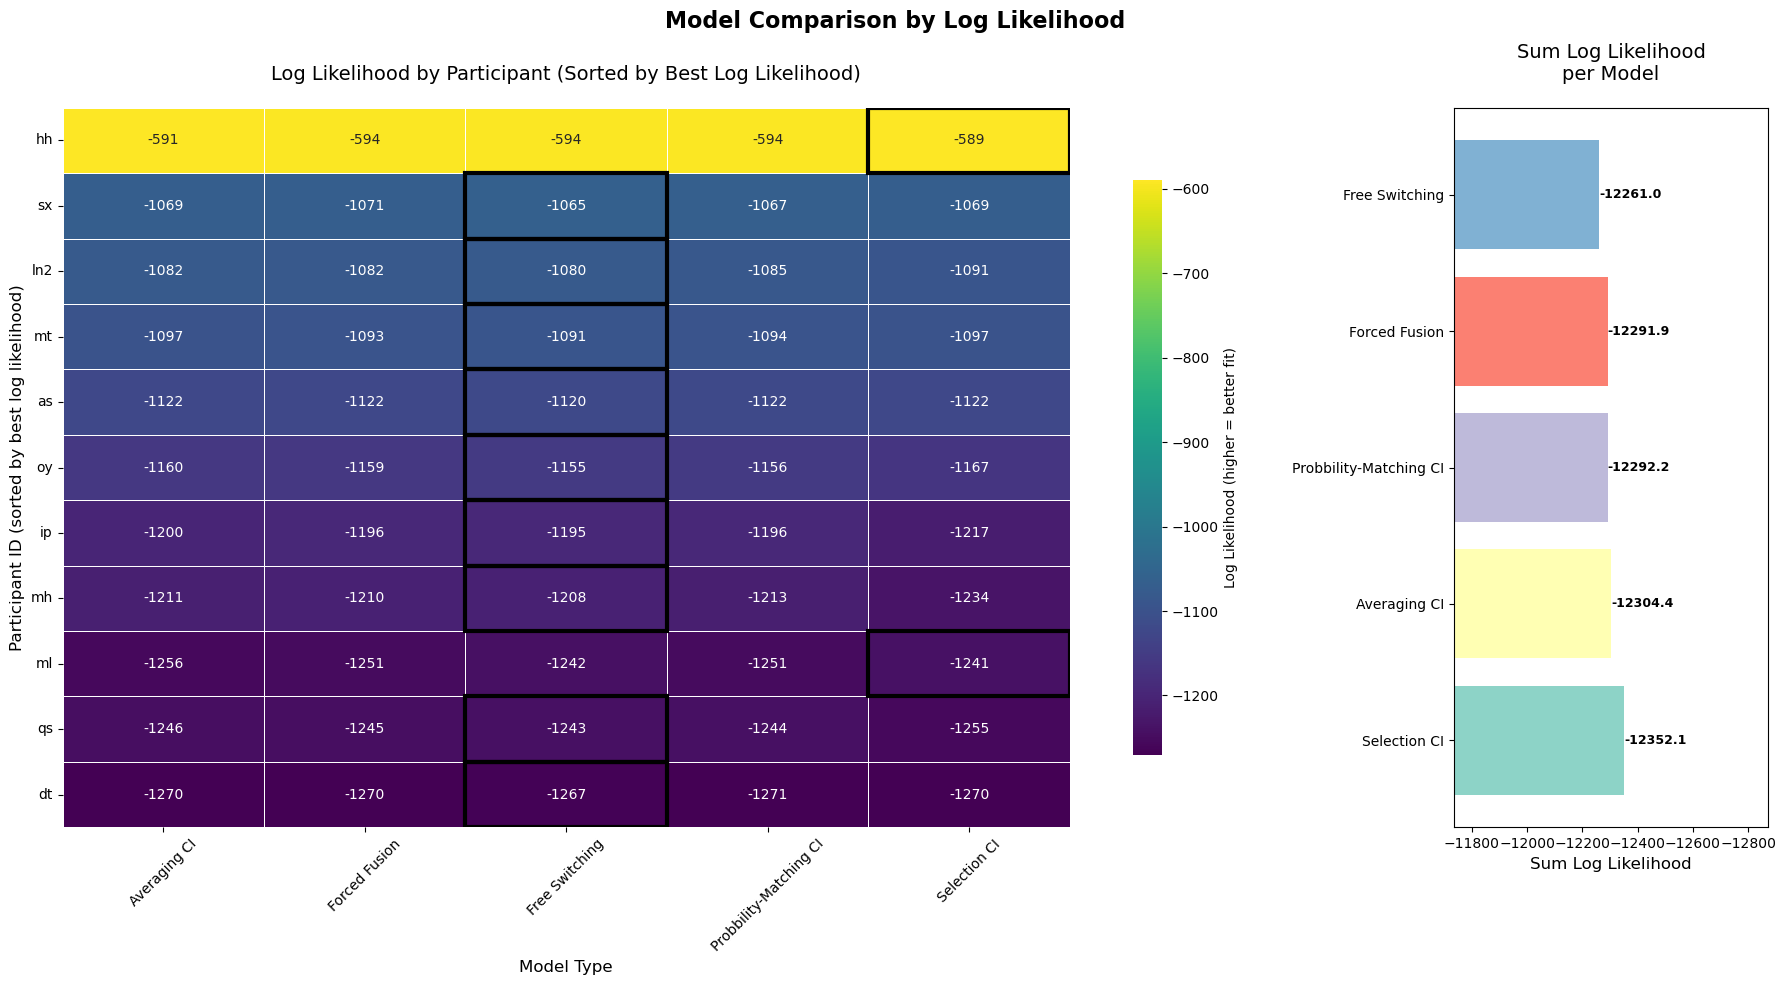


PARTICIPANT RANKING TABLE (sorted by best Log Likelihood)
Rank Participant  Best LL    Best Model         Sum ΔAIC   Performance    
------------------------------------------------------------------------------------------
1    hh           -589       Selection CI       32.1       Excellent fit  
2    sx           -1065      Free Switching     25.2       Moderate fit   
3    ln2          -1080      Free Switching     30.5       Moderate fit   
4    mt           -1091      Free Switching     25.4       Moderate fit   
5    as           -1120      Free Switching     9.0        Moderate fit   
6    oy           -1155      Free Switching     37.8       Moderate fit   
7    ip           -1195      Free Switching     62.3       Moderate fit   
8    mh           -1208      Free Switching     64.0       Poor fit       
9    ml           -1241      Selection CI       72.7       Poor fit       
10   qs           -1243      Free Switching     30.2       Poor fit       
11   dt           -1267  

In [39]:
# Plot Log Likelihood Comparison Table (similar to ΔAIC visualization)
import matplotlib.pyplot as plt
import seaborn as sns


def plot_log_likelihood_comparison_table(df_results):
    """Create a comprehensive log likelihood comparison plot similar to ΔAIC visualization"""
    
    # Sort participants by their best (highest) log likelihood values
    participant_best_ll = df_results.groupby('participantID')['logLikelihood'].max().sort_values(ascending=False)
    sorted_participants = participant_best_ll.index.tolist()
    
    # Create the pivot table with sorted participants for log likelihoods
    df_log_likelihood = df_results.pivot(index='participantID', columns='modelType', values='logLikelihood')
    df_log_likelihood = df_log_likelihood.reindex(sorted_participants)
    
    # Find best model for each participant (highest log likelihood)
    best_models = []
    for participant in sorted_participants:
        participant_data = df_results[df_results['participantID'] == participant]
        best_model = participant_data.loc[participant_data['logLikelihood'].idxmax(), 'modelType']
        best_models.append(best_model)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [4, 1]})
    fig.suptitle('Model Comparison by Log Likelihood', fontsize=16, fontweight='bold')
    
    # Main heatmap with log likelihood values
    sns.heatmap(df_log_likelihood, 
                annot=True, 
                fmt='.0f', 
                cmap='viridis', 
                ax=ax1,
                cbar_kws={'label': 'Log Likelihood (higher = better fit)', 'shrink': 0.8},
                linewidths=0.5,
                linecolor='white')
    
    ax1.set_title('Log Likelihood by Participant (Sorted by Best Log Likelihood)', fontsize=14, pad=20)
    ax1.set_ylabel('Participant ID (sorted by best log likelihood)', fontsize=12)
    ax1.set_xlabel('Model Type', fontsize=12)
    
    # Rotate x-axis labels for better readability
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', rotation=0, labelsize=10)
    
    # Add best model indicators (gold borders)
    for i, (participant, best_model) in enumerate(zip(sorted_participants, best_models)):
        # Find column index of best model
        model_cols = df_log_likelihood.columns.tolist()
        if best_model in model_cols:
            col_idx = model_cols.index(best_model)
            # Add a gold border to highlight best model
            rect = plt.Rectangle((col_idx, i), 1, 1, fill=False, edgecolor='black', lw=3)
            ax1.add_patch(rect)
    
    # Side panel: Sum Log Likelihood per model - sum across rows (participants) for each model column
    sum_ll = df_log_likelihood.sum(axis=0).sort_values()  # sum across participants for each model
    colors = plt.cm.Set3(range(len(sum_ll)))
    
    bars = ax2.barh(range(len(sum_ll)), sum_ll.values, color=colors)
    ax2.set_yticks(range(len(sum_ll)))
    ax2.set_yticklabels(sum_ll.index, fontsize=10)
    ax2.set_xlabel('Sum Log Likelihood', fontsize=12)
    ax2.set_title('Sum Log Likelihood\nper Model', fontsize=14, pad=20)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, sum_ll.values)):
        ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                 f'{val:.1f}',
                 ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Set limits for the heatmap axes
    ax2.set_xlim(min(sum_ll.values)*0.95, max(sum_ll.values)*1.05)

    # Adjust layout
    plt.tight_layout()
    
    plt.show()
    
    # Print summary table
    print("\n" + "="*90)
    print("PARTICIPANT RANKING TABLE (sorted by best Log Likelihood)")
    print("="*90)
    print(f"{'Rank':<4} {'Participant':<12} {'Best LL':<10} {'Best Model':<18} {'Sum ΔAIC':<10} {'Performance':<15}")
    print("-"*90)
    
    for rank, participant in enumerate(sorted_participants, 1):
        participant_data = df_results[df_results['participantID'] == participant]
        sum_delta_aic = participant_data['delta_AIC'].sum()
        best_ll = participant_data['logLikelihood'].max()
        best_model = participant_data.loc[participant_data['logLikelihood'].idxmax(), 'modelType']
        
        if best_ll >= -600:
            performance = "Excellent fit"
        elif best_ll >= -900:
            performance = "Good fit"
        elif best_ll >= -1200:
            performance = "Moderate fit"
        else:
            performance = "Poor fit"
            
        print(f"{rank:<4} {participant:<12} {best_ll:<10.0f} {best_model:<18} {sum_delta_aic:<10.1f} {performance:<15}")
    
    return df_log_likelihood, best_models
# ...existing code...

    return df_log_likelihood, best_models

# Create the enhanced log likelihood visualization
ll_table, ll_best_models = plot_log_likelihood_comparison_table(df_results)

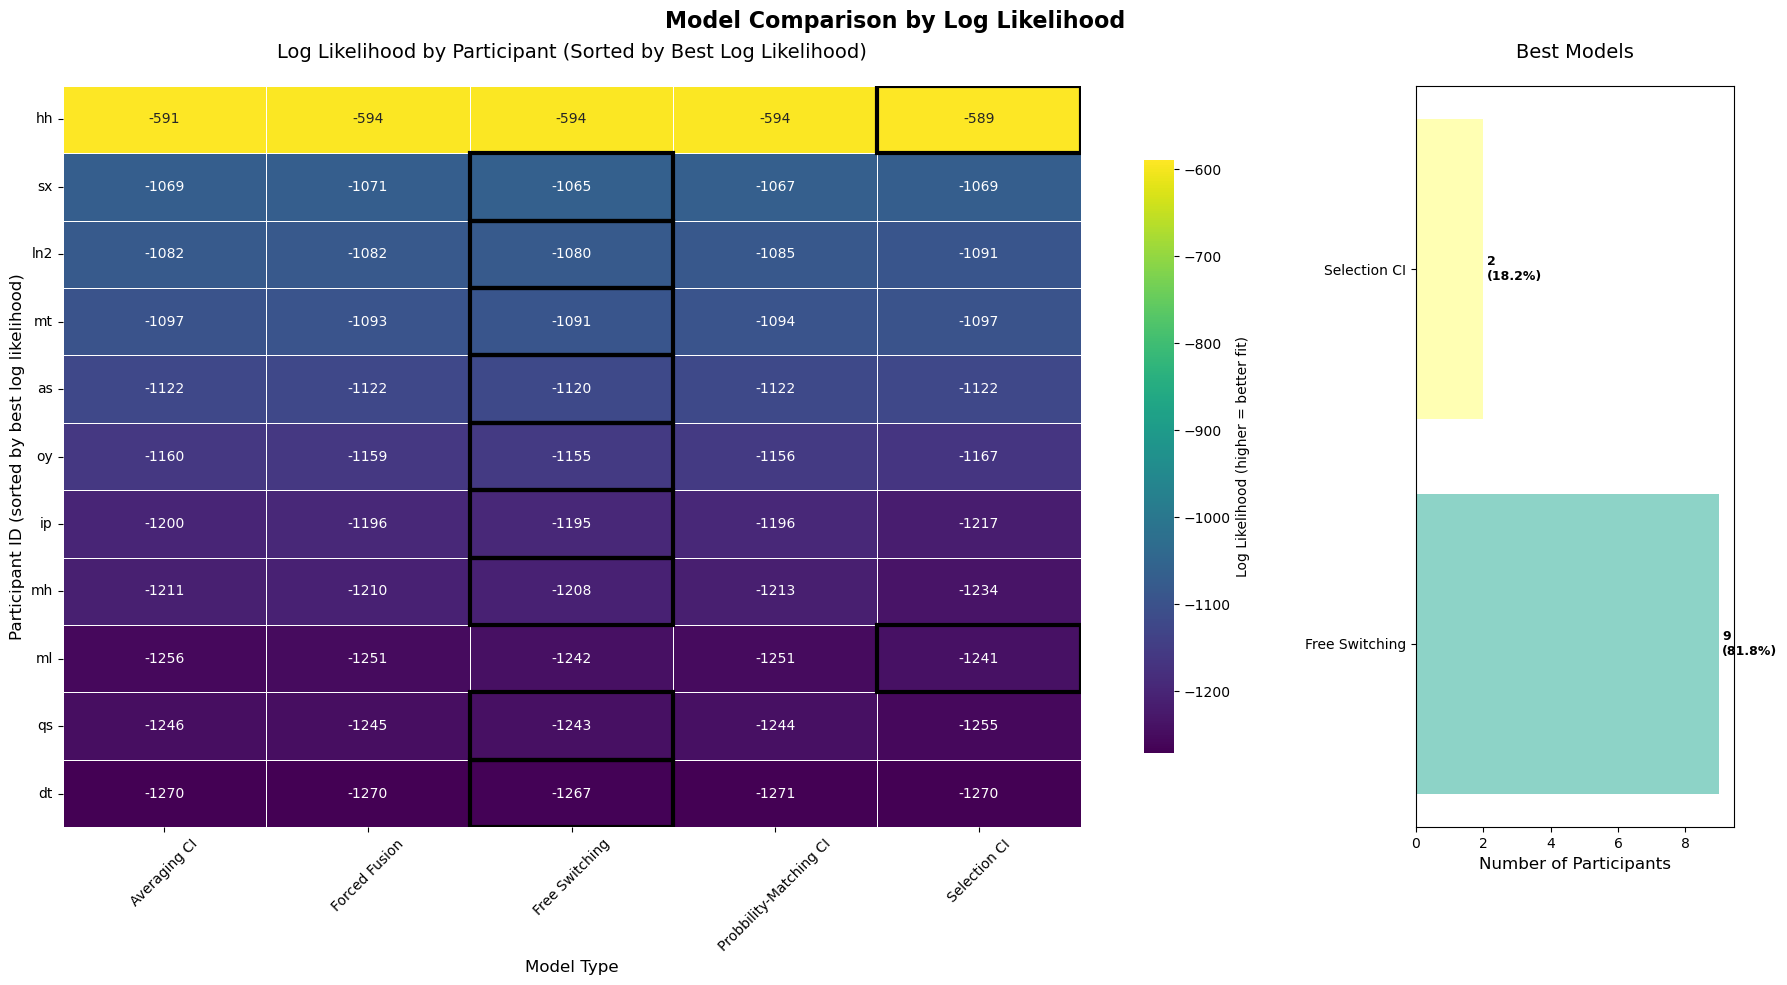


PARTICIPANT RANKING TABLE (sorted by best Log Likelihood)
Rank Participant  Best LL    Best Model         Sum ΔAIC   Performance    
------------------------------------------------------------------------------------------
1    hh           -589       Selection CI       32.1       Excellent fit  
2    sx           -1065      Free Switching     25.2       Moderate fit   
3    ln2          -1080      Free Switching     30.5       Moderate fit   
4    mt           -1091      Free Switching     25.4       Moderate fit   
5    as           -1120      Free Switching     9.0        Moderate fit   
6    oy           -1155      Free Switching     37.8       Moderate fit   
7    ip           -1195      Free Switching     62.3       Moderate fit   
8    mh           -1208      Free Switching     64.0       Poor fit       
9    ml           -1241      Selection CI       72.7       Poor fit       
10   qs           -1243      Free Switching     30.2       Poor fit       
11   dt           -1267  

In [40]:
# Plot Log Likelihood Comparison Table (similar to ΔAIC visualization)
import matplotlib.pyplot as plt
import seaborn as sns

def plot_log_likelihood_comparison_table(df_results):
    """Create a comprehensive log likelihood comparison plot similar to ΔAIC visualization"""
    
    # Sort participants by their best (highest) log likelihood values
    participant_best_ll = df_results.groupby('participantID')['logLikelihood'].max().sort_values(ascending=False)
    sorted_participants = participant_best_ll.index.tolist()
    
    # Create the pivot table with sorted participants for log likelihoods
    df_log_likelihood = df_results.pivot(index='participantID', columns='modelType', values='logLikelihood')
    df_log_likelihood = df_log_likelihood.reindex(sorted_participants)
    
    # Find best model for each participant (highest log likelihood)
    best_models = []
    for participant in sorted_participants:
        participant_data = df_results[df_results['participantID'] == participant]
        best_model = participant_data.loc[participant_data['logLikelihood'].idxmax(), 'modelType']
        best_models.append(best_model)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [4, 1]})
    fig.suptitle('Model Comparison by Log Likelihood', fontsize=16, fontweight='bold')
    
    # Main heatmap with log likelihood values
    sns.heatmap(df_log_likelihood, 
                annot=True, 
                fmt='.0f', 
                cmap='viridis', 
                ax=ax1,
                cbar_kws={'label': 'Log Likelihood (higher = better fit)', 'shrink': 0.8},
                linewidths=0.5,
                linecolor='white')
    
    ax1.set_title('Log Likelihood by Participant (Sorted by Best Log Likelihood)', fontsize=14, pad=20)
    ax1.set_ylabel('Participant ID (sorted by best log likelihood)', fontsize=12)
    ax1.set_xlabel('Model Type', fontsize=12)
    
    # Rotate x-axis labels for better readability
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', rotation=0, labelsize=10)
    
    # Add best model indicators (gold borders)
    for i, (participant, best_model) in enumerate(zip(sorted_participants, best_models)):
        # Find column index of best model
        model_cols = df_log_likelihood.columns.tolist()
        if best_model in model_cols:
            col_idx = model_cols.index(best_model)
            # Add a gold border to highlight best model
            rect = plt.Rectangle((col_idx, i), 1, 1, fill=False, edgecolor='black', lw=3)
            ax1.add_patch(rect)
    
    # Side panel: Best model summary
    
    best_model_counts = pd.Series(best_models).value_counts()
    colors = plt.cm.Set3(range(len(best_model_counts)))
    
    bars = ax2.barh(range(len(best_model_counts)), best_model_counts.values, color=colors)
    ax2.set_yticks(range(len(best_model_counts)))
    ax2.set_yticklabels(best_model_counts.index, fontsize=10)
    ax2.set_xlabel('Number of Participants', fontsize=12)
    ax2.set_title('Best Models', fontsize=14, pad=20)
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, best_model_counts.values)):
        percentage = (count / len(sorted_participants)) * 100
        ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{count}\n({percentage:.1f}%)', 
                ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    
    plt.show()
    
    # Print summary table
    print("\n" + "="*90)
    print("PARTICIPANT RANKING TABLE (sorted by best Log Likelihood)")
    print("="*90)
    print(f"{'Rank':<4} {'Participant':<12} {'Best LL':<10} {'Best Model':<18} {'Sum ΔAIC':<10} {'Performance':<15}")
    print("-"*90)
    
    for rank, participant in enumerate(sorted_participants, 1):
        participant_data = df_results[df_results['participantID'] == participant]
        sum_delta_aic = participant_data['delta_AIC'].sum()
        best_ll = participant_data['logLikelihood'].max()
        best_model = participant_data.loc[participant_data['logLikelihood'].idxmax(), 'modelType']
        
        if best_ll >= -600:
            performance = "Excellent fit"
        elif best_ll >= -900:
            performance = "Good fit"
        elif best_ll >= -1200:
            performance = "Moderate fit"
        else:
            performance = "Poor fit"
            
        print(f"{rank:<4} {participant:<12} {best_ll:<10.0f} {best_model:<18} {sum_delta_aic:<10.1f} {performance:<15}")
    
    return df_log_likelihood, best_models

# Create the enhanced log likelihood visualization
ll_table, ll_best_models = plot_log_likelihood_comparison_table(df_results)

In [41]:
df_results

,participantID,modelType,fittedParams,AIC,BIC,logLikelihood,n_conditions,nParameters,AIC_recalculated,delta_AIC
0,sx,Free Switching,"[0.00100676619969306, 0.05494942788865409, 0.3...",2145.147761,2179.597963,-1064.573881,548,8,2145.147761,0.000000
1,sx,Averaging CI,"[0.0010001342422045756, 0.33921005301171236, 0...",2151.719866,2181.863793,-1068.859933,548,7,2151.719866,6.572105
2,sx,Forced Fusion,"[0.0010010687986155842, 0.33265441676415497, 0...",2153.654938,2179.492590,-1070.827469,548,6,2153.654938,8.507177
3,sx,Selection CI,"[0.023234512085853337, 0.17895699405860788, 0....",2151.861971,2182.005898,-1068.930985,548,7,2151.861971,6.714210
4,sx,Probbility-Matching CI,"[0.013386030469147936, 0.24978987224322502, 0....",2148.562957,2178.706884,-1067.281479,548,7,2148.562957,3.415196
5,mt,Averaging CI,"[0.060016318320364956, 0.14157681437677516, 0....",2207.909712,2235.073443,-1096.954856,358,7,2207.909712,10.099783
6,mt,Forced Fusion,"[0.03511450789570808, 0.15256166017055506, 0.4...",2197.809930,2221.093127,-1092.904965,358,6,2197.809930,0.000000
7,mt,Probbility-Matching CI,"[0.035726815013191665, 0.15696676968664147, 0....",2202.745654,2229.909385,-1094.372827,358,7,2202.745654,4.935725
8,mt,Selection CI,"[0.05397702112051753, 0.07375835781862317, 0.1...",2207.386095,2234.549826,-1096.693047,358,7,2207.386095,9.576165
9,mt,Free Switching,"[0.037807366781214546, 0.14188179661953804, 0....",2198.640728,2229.684992,-1091.320364,358,8,2198.640728,0.830799


In [42]:
import numpy as np
import matplotlib.pyplot as plt
def plot_parameter_fits(df_results,model_name='Log-Space Causal'):
    # example fittedParams for Log-Space Causal model
    # fittedParams: [lambda_1, sigma_a, sigma_v, sigma_a2,lambda_2, lambda_3]
    participantIDs= sorted(df_results['participantID'].unique())
    modelTypes= sorted(df_results['modelType'].unique())
    paramFits= {}
    for pid in participantIDs:
        participant_data = df_results[df_results['participantID'] == pid]
        pid_lognorm_fit = participant_data[participant_data['modelType'] == model_name]
        lambda_1_Fit = pid_lognorm_fit['fittedParams'].values[0][0]
        sigma_a_Fit = pid_lognorm_fit['fittedParams'].values[0][1]
        sigma_v_Fit = pid_lognorm_fit['fittedParams'].values[0][2]
        p_c= pid_lognorm_fit['fittedParams'].values[0][3]
        sigma_a2_Fit = pid_lognorm_fit['fittedParams'].values[0][4]
        lambda_2_Fit = pid_lognorm_fit['fittedParams'].values[0][5]
        lambda_3_Fit = pid_lognorm_fit['fittedParams'].values[0][6]    
        print(f"Participant {pid}: lambda_1={lambda_1_Fit}, sigma_a={sigma_a_Fit}, sigma_v={sigma_v_Fit}, p_c={p_c},sigma_a2={sigma_a2_Fit}, lambda_2={lambda_2_Fit}, lambda_3={lambda_3_Fit}")
        paramFits[pid]= {
            'lambda_1': lambda_1_Fit,
            'sigma_a': sigma_a_Fit,
            'sigma_v': sigma_v_Fit,
            'p_c': p_c,
            'sigma_a2': sigma_a2_Fit,
            'lambda_2': lambda_2_Fit,
            'lambda_3': lambda_3_Fit
        }

    




    # plot the parameter fits scatter plot with jittered x-axis values for each parameter
    plt.figure(figsize=(10, 6))
    parameters = ['lambda_1', 'sigma_a', 'sigma_v', 'p_c', 'sigma_a2', 'lambda_2', 'lambda_3']
    x_positions = np.arange(len(parameters))
    for pid in participantIDs:
        if pid=='all':
            # color='red'
            # fits = paramFits[pid]
            # y_values = [fits[param] for param in parameters]
            # plt.scatter(x_positions, y_values, label=pid, color=color, s=100, edgecolor='red')
            continue
        fits = paramFits[pid]
        y_values = [fits[param] for param in parameters]
        # Add jitter to x positions
        jitter = np.random.uniform(-0.1, 0.1, size=len(parameters))
        plt.scatter(x_positions + jitter, y_values, label=pid)

    # Add mean markers for each parameter
    for i, param in enumerate(parameters):
        mean_value = np.mean([paramFits[pid][param] for pid in participantIDs])
        plt.scatter(i, mean_value, color='black', marker='D', s=50, alpha=0.8,label='Mean' if i == 0 else "")

    plt.xticks(x_positions, parameters)
    plt.ylabel('Fitted Parameter Value')
    plt.title('Fitted Parameters for Log-Space Causal Model Across Participants')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


plot_parameter_fits(df_results,model_name='Log-Space Causal')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# Plot Delta Log Likelihood Comparison Table
import matplotlib.pyplot as plt
import seaborn as sns

def plot_delta_log_likelihood_comparison_table(df_results):
    """Create a comprehensive delta log likelihood comparison plot"""
    
    # Sort participants by sum of delta_LL (lower is better since it's distance from best)
    participant_delta_ll_sums = df_results.groupby('participantID')['delta_LL'].sum().sort_values()
    sorted_participants = participant_delta_ll_sums.index.tolist()
    
    # Create the pivot table with sorted participants for delta log likelihoods
    df_delta_ll = df_results.pivot(index='participantID', columns='modelType', values='delta_LL')
    df_delta_ll = df_delta_ll.reindex(sorted_participants)
    
    # Find best model for each participant (lowest delta_LL = highest log likelihood)
    best_models = []
    for participant in sorted_participants:
        participant_data = df_results[df_results['participantID'] == participant]
        best_model = participant_data.loc[participant_data['delta_LL'].idxmin(), 'modelType']
        best_models.append(best_model)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [4, 1]})
    fig.suptitle('Model Comparison by ΔLog Likelihood', fontsize=16, fontweight='bold')
    
    # Main heatmap with delta log likelihood values
    sns.heatmap(df_delta_ll, 
                annot=True, 
                fmt='.1f', 
                cmap='RdYlBu_r', 
                center=0,
                ax=ax1,
                cbar_kws={'label': 'ΔLog Likelihood (lower = better fit)', 'shrink': 0.8},
                linewidths=0.5,
                linecolor='white')
    
    ax1.set_title('Delta Log Likelihood by Participant (Sorted by Sum of ΔLL)', fontsize=14, pad=20)
    ax1.set_ylabel('Participant ID (sorted by sum of ΔLL)', fontsize=12)
    ax1.set_xlabel('Model Type', fontsize=12)
    
    # Rotate x-axis labels for better readability
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', rotation=0, labelsize=10)
    
    # Add best model indicators (black borders)
    for i, (participant, best_model) in enumerate(zip(sorted_participants, best_models)):
        # Find column index of best model
        model_cols = df_delta_ll.columns.tolist()
        if best_model in model_cols:
            col_idx = model_cols.index(best_model)
            # Add a border to highlight best model
            rect = plt.Rectangle((col_idx, i), 1, 1, fill=False, edgecolor='black', lw=3)
            ax1.add_patch(rect)
    
    # Side panel: Sum Delta LL per model
    sum_delta_ll = df_delta_ll.sum(axis=0).sort_values()
    colors = plt.cm.Set3(range(len(sum_delta_ll)))
    
    bars = ax2.barh(range(len(sum_delta_ll)), sum_delta_ll.values, color=colors)
    ax2.set_yticks(range(len(sum_delta_ll)))
    ax2.set_yticklabels(sum_delta_ll.index, fontsize=10)
    ax2.set_xlabel('Sum ΔLog Likelihood', fontsize=12)
    ax2.set_title('Sum ΔLog Likelihood\nper Model', fontsize=14, pad=20)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, sum_delta_ll.values)):
        ax2.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                 f'{val:.1f}',
                 ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    # Line plot showing sum of delta LL per model
    plt.figure(figsize=(10, 6))
    plt.plot(sum_delta_ll.index, sum_delta_ll.values, marker='o', linestyle='-', color='purple')
    plt.title('Sum of ΔLog Likelihood Across All Participants by Model', fontsize=16)
    plt.xlabel('Model Type', fontsize=14)
    plt.ylabel('Sum of ΔLog Likelihood', fontsize=14)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    # Add value labels on points
    for i, value in enumerate(sum_delta_ll.values):
        plt.text(i, value + 0.5, f'{value:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\n" + "="*90)
    print("PARTICIPANT RANKING TABLE (sorted by sum of ΔLog Likelihood)")
    print("="*90)
    print(f"{'Rank':<4} {'Participant':<12} {'Sum ΔLL':<10} {'Best Model':<18} {'Min ΔLL':<10} {'Performance':<15}")
    print("-"*90)
    
    for rank, participant in enumerate(sorted_participants, 1):
        participant_data = df_results[df_results['participantID'] == participant]
        sum_delta_ll = participant_data['delta_LL'].sum()
        min_delta_ll = participant_data['delta_LL'].min()
        best_model = participant_data.loc[participant_data['delta_LL'].idxmin(), 'modelType']
        
        if sum_delta_ll <= 5:
            performance = "Excellent fit"
        elif sum_delta_ll <= 15:
            performance = "Good fit"
        elif sum_delta_ll <= 30:
            performance = "Moderate fit"
        else:
            performance = "Poor fit"
            
        print(f"{rank:<4} {participant:<12} {sum_delta_ll:<10.1f} {best_model:<18} {min_delta_ll:<10.1f} {performance:<15}")
    
    return df_delta_ll, best_models, participant_delta_ll_sums

# Create the delta log likelihood visualization
delta_ll_table, delta_ll_best_models, delta_ll_sums = plot_delta_log_likelihood_comparison_table(df_results)

KeyError: 'Column not found: delta_LL'

In [ ]:
# Create detailed parameter description table
def create_parameter_description_table():
    """Generate a LaTeX table describing parameters for each model"""
    
    latex = r"""\begin{table}[htbp]
\centering
\caption{Model Parameter Descriptions}
\label{tab:model_parameters}
\begin{threeparttable}
\begin{tabular}{l c c c c c}
\toprule
\textbf{Model} & \textbf{Lapse} & \textbf{Sensory} & \textbf{Prior} & \textbf{Other} & \textbf{Total} \\
 & \textbf{Rates} & \textbf{Noise} & \textbf{$p_c$} & \textbf{Params} & \textbf{$n$} \\
\midrule
Free Switching & 3 & 3 & \checkmark & $w$ & 8 \\
Forced Fusion & 3 & 3 & -- & -- & 6 \\
Prob-Matching CI & 3 & 3 & \checkmark & -- & 7 \\
Averaging CI & 3 & 3 & \checkmark & -- & 7 \\
Log-Linear Mismatch & 3 & 3 & \checkmark & -- & 7 \\
Selection CI & 3 & 3 & \checkmark & -- & 7 \\
\bottomrule
\end{tabular}
\begin{tablenotes}[flushleft]
\small
\item \textit{Lapse Rates:} $\lambda_1, \lambda_2, \lambda_3$ for low-noise auditory, high-noise auditory, and cross-modal conditions.
\item \textit{Sensory Noise:} $\sigma_a, \sigma_v, \sigma_{a2}$ representing auditory (low-noise), visual, and auditory (high-noise) standard deviations in log-space.
\item \textit{Prior:} $p_c$ is the prior probability of a common cause.
\item \textit{Other:} $w$ is the switching weight parameter (Free Switching model only).
\end{tablenotes}
\end{threeparttable}
\end{table}"""
    
    return latex

latex_param_table = create_parameter_description_table()

print("LaTeX Parameter Description Table:")
print("=" * 80)
print(latex_param_table)
print("\n" + "=" * 80)

LaTeX Parameter Description Table:
\begin{table}[htbp]
\centering
\caption{Model Parameter Descriptions}
\label{tab:model_parameters}
\begin{threeparttable}
\begin{tabular}{l c c c c c}
\toprule
\textbf{Model} & \textbf{Lapse} & \textbf{Sensory} & \textbf{Prior} & \textbf{Other} & \textbf{Total} \\
 & \textbf{Rates} & \textbf{Noise} & \textbf{$p_c$} & \textbf{Params} & \textbf{$n$} \\
\midrule
Free Switching & 3 & 3 & \checkmark & $w$ & 8 \\
Forced Fusion & 3 & 3 & -- & -- & 6 \\
Prob-Matching CI & 3 & 3 & \checkmark & -- & 7 \\
Averaging CI & 3 & 3 & \checkmark & -- & 7 \\
Log-Linear Mismatch & 3 & 3 & \checkmark & -- & 7 \\
Selection CI & 3 & 3 & \checkmark & -- & 7 \\
\bottomrule
\end{tabular}
\begin{tablenotes}[flushleft]
\small
\item \textit{Lapse Rates:} $\lambda_1, \lambda_2, \lambda_3$ for low-noise auditory, high-noise auditory, and cross-modal conditions.
\item \textit{Sensory Noise:} $\sigma_a, \sigma_v, \sigma_{a2}$ representing auditory (low-noise), visual, and auditory (h